In [1]:
import os
import sys
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# from tqdm.rich import tqdm
from tqdm import tqdm
import h5py

import seaborn as sns
import matplotlib.pylab as plt
sys.path.append("..") 
from emd import emd_pot
from data import get_database_path, get_h5_files, read_h5_file
from utils import load_toml_config
np.random.seed(114514)

In [2]:
from data import sample_matrix, sample_pairs

# Sample processing

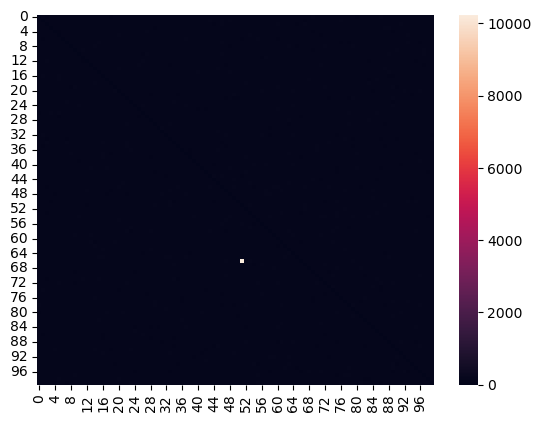

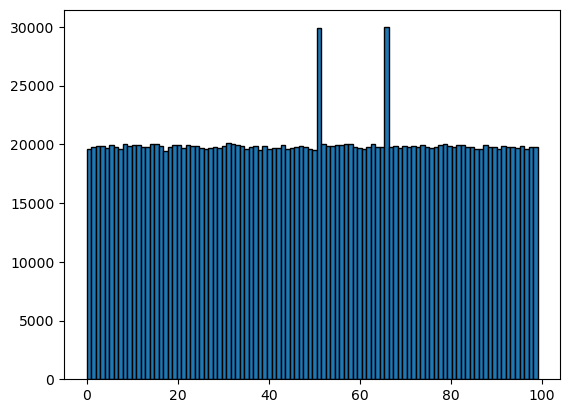

In [3]:
test_n_events = 100
test_n_pairs = 1000000
test_pairs = sample_pairs(test_n_events, test_n_pairs)
test_matrix = sample_matrix(test_n_events, test_pairs)
ax = sns.heatmap(test_matrix)
plt.show()
plt.hist(test_pairs.flatten(), bins=test_n_events, edgecolor='black')
plt.show()

# Sample Pairs and Calculate EMD

In [4]:
from data import sample_pairs_with_emd, store_emds_with_pairs
from utils import load_toml_config

In [5]:
files = load_toml_config("file")
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

print(files.keys())
bkg = read_h5_file(database_path, files["SM"])
# SM processes

neutral_boson = read_h5_file(database_path, files["neutral_boson"])
# A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

leptoquark = read_h5_file(database_path, files["leptoquark"])
# A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

neutral_Higgs = read_h5_file(database_path, files["neutral_Higgs"])
# A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

charged_Higgs = read_h5_file(database_path, files["charged_Higgs"])
# A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino


dict_keys(['SM', 'neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs'])


In [6]:
EMD_config = load_toml_config('EMD')

In [7]:
print(EMD_config)
particle_type_scale = EMD_config['particle_type_scale']
pair = EMD_config['n_pair']
norm = EMD_config['norm']
save_emd = EMD_config['save_emd']

{'particle_type_scale': 10, 'n_pair': 2000000, 'norm': False, 'save_emd': True}


In [8]:
bkg_pairs, bkg_emds = sample_pairs_with_emd(bkg, n_pairs=pair, particle_type_scale=particle_type_scale, norm=norm)


neutral_boson_pairs, neutral_boson_emds = sample_pairs_with_emd(neutral_boson, particle_type_scale=particle_type_scale, norm=norm)


leptoquark_pairs, leptoquark_emds = sample_pairs_with_emd(leptoquark, particle_type_scale=particle_type_scale, norm=norm)


neutral_higgs_pairs, neutral_higgs_emds = sample_pairs_with_emd(neutral_Higgs, particle_type_scale=particle_type_scale, norm=norm)


charged_higgs_pairs, charged_higgs_emds = sample_pairs_with_emd(charged_Higgs, particle_type_scale=particle_type_scale, norm=norm)

if save_emd:
    store_emds_with_pairs(bkg_emds, bkg_pairs, "bkg_emds_type_scale{}.h5".format(particle_type_scale))
    store_emds_with_pairs(neutral_boson_emds, neutral_boson_pairs, "neutral_boson_emds_type_scale{}.h5".format(particle_type_scale))
    store_emds_with_pairs(leptoquark_emds, leptoquark_pairs, "leptoquark_emds_type_scale{}.h5".format(particle_type_scale))
    store_emds_with_pairs(neutral_higgs_emds, neutral_higgs_pairs, "neutral_higgs_emds_type_scale{}.h5".format(particle_type_scale))
    store_emds_with_pairs(charged_higgs_emds, charged_higgs_pairs, "charged_higgs_emds_type_scale{}.h5".format(particle_type_scale))

100%|██████████| 3801360/3801360 [03:13<00:00, 19660.87it/s]


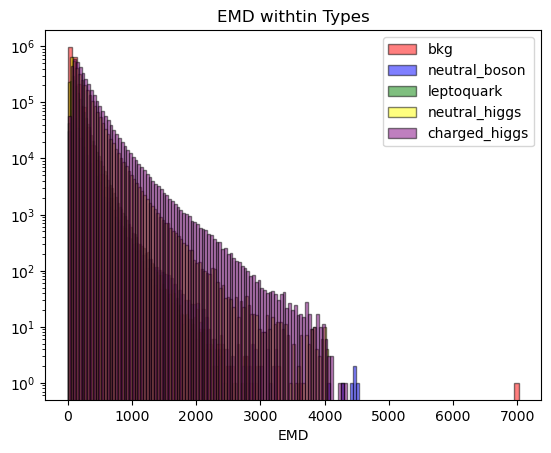

In [9]:
plt.hist(bkg_emds, bins=100, edgecolor='black', color='red', alpha=0.5, label='bkg')
plt.hist(neutral_boson_emds, bins=100, edgecolor='black', color='blue', alpha=0.5, label='neutral_boson')
plt.hist(leptoquark_emds, bins=100, edgecolor='black', color='green', alpha=0.5, label='leptoquark')
plt.hist(neutral_higgs_emds, bins=100, edgecolor='black', color='yellow', alpha=0.5, label='neutral_higgs')
plt.hist(charged_higgs_emds, bins=100, edgecolor='black', color='purple', alpha=0.5, label='charged_higgs')
plt.yscale('log')
plt.legend()
plt.title("EMD withtin Types")
plt.xlabel("EMD")
plt.show()

In [10]:
def sample_pairs_from_diff_dataset(events1, events2, n_pairs, particle_type_scale=0, norm=False):
    index1 = np.random.randint(0, len(events1), n_pairs)
    index2 = np.random.randint(0, len(events2), n_pairs)
    pairs = np.stack([index1, index2], axis=1)
    emds = np.zeros(n_pairs)
    for i, (idx1, idx2) in enumerate(tqdm(pairs)):
        emds[i] = emd_pot(events1[idx1], events2[idx2], particle_type_scale=particle_type_scale, norm=norm)
    return pairs, emds

In [11]:
from data import sample_pairs_from_diff_dataset

In [12]:
bkg_neutral_boson_pairs, bkg_neutral_boson_emds = sample_pairs_from_diff_dataset(bkg, neutral_boson, pair, particle_type_scale=particle_type_scale, norm=norm)
bkg_leptoquark_pairs, bkg_leptoquark_emds = sample_pairs_from_diff_dataset(bkg, leptoquark, pair, particle_type_scale=particle_type_scale, norm=norm)
bkg_neutral_higgs_pairs, bkg_neutral_higgs_emds = sample_pairs_from_diff_dataset(bkg, neutral_Higgs, pair, particle_type_scale=particle_type_scale, norm=norm)
bkg_charged_higgs_pairs, bkg_charged_higgs_emds = sample_pairs_from_diff_dataset(bkg, charged_Higgs, pair, particle_type_scale=particle_type_scale, norm=norm)

100%|██████████| 2000000/2000000 [01:43<00:00, 19406.63it/s]


In [1]:
bins = np.linspace(0, 1000, 100)
# bins = 100
plt.hist(bkg_emds, bins=bins, edgecolor='black', color='red', alpha=0.5, label='bkg')
plt.hist(bkg_neutral_boson_emds, bins=bins, edgecolor='black', color='blue', alpha=0.5, label='neutral_boson')
# plt.hist(bkg_leptoquark_emds, bins=bins, edgecolor='black', color='green', alpha=0.5, label='leptoquark')
# plt.hist(bkg_neutral_higgs_emds, bins=bins, edgecolor='black', color='yellow', alpha=0.5, label='neutral_higgs')
# plt.hist(bkg_charged_higgs_emds, bins=bins, edgecolor='black', color='purple', alpha=0.5, label='charged_higgs')
# plt.yscale('log')
plt.legend()
plt.title("EMD between bkg and sig")
plt.xlabel("EMD")
plt.show()

NameError: name 'np' is not defined

In [ ]:
bins = np.linspace(0, 1000, 100)
# bins = 100
plt.hist(bkg_emds, bins=bins, edgecolor='black', color='red', alpha=0.5, label='bkg')
plt.hist(bkg_neutral_boson_emds, bins=bins, edgecolor='black', color='blue', alpha=0.5, label='neutral_boson')
plt.hist(bkg_leptoquark_emds, bins=bins, edgecolor='black', color='green', alpha=0.5, label='leptoquark')
plt.hist(bkg_neutral_higgs_emds, bins=bins, edgecolor='black', color='yellow', alpha=0.5, label='neutral_higgs')
plt.hist(bkg_charged_higgs_emds, bins=bins, edgecolor='black', color='purple', alpha=0.5, label='charged_higgs')
# plt.yscale('log')
plt.legend()
plt.title("EMD between bkg and sig")
plt.xlabel("EMD")
plt.show()